In [1]:
from ncmw.analysis.similarity import jaccard_similarity_matrices, jaccard_similarity
from ncmw.analysis.medium import compute_COMPM, compute_fvas
from ncmw.utils import get_models, get_result_path, SEPERATOR
from ncmw.utils import get_default_medium, get_default_configs, get_biomass_reaction
from ncmw.setup_models.setup import gapfill_medium, set_default_configs_and_snm3_medium
from ncmw.analysis.sekretion_uptake import transport_reactions, table_ex_transport, sekretion_uptake_fva
from ncmw.visualization import uptake_sekretion_venn_diagrams, plot_pairwise_growth_relation_per_weight, plot_community_interaction, plot_community_uptake_graph

import matplotlib.pyplot as plt
import numpy as np

from cobra.flux_analysis import flux_variability_analysis
import cobra

from ncmw.community.community_models import ShuttleCommunityModel, BagOfReactionsModel
from ncmw.community.community_analysis import compute_fair_weights, compute_dominant_weights

In [2]:
from cobra import Model, Reaction, Metabolite

community_model = Model("Community")

In [5]:
models = get_models(folder="snm3_models", prefix="results/default_project_name/setup/")

exchanges = []
metabolite = []
for model in models:
    for ex in model.exchanges:
        if ex.id not in exchanges:
            exchanges.append(ex.id)
            metabolite.append(list(ex.metabolites.keys())[0])

In [6]:
external_metabolites = []
for met in metabolite:
    new_met = Metabolite(met.id, formula=met.formula, name=met.name, compartment="e", charge=met.charge)
    external_metabolites.append(new_met)
community_model.add_metabolites(external_metabolites)
for met in external_metabolites:
    community_model.add_boundary(met, type="exchange")

In [7]:
from ncmw.utils import get_biomass_reaction
for m in models:
    metabolites = []
    for met in m.metabolites:
        met.id = met.id + "_" + m.id.split("_")[0]
        met.compartment = m.id.split("_")[0] + "_" + met.compartment
        metabolites.append(met)
    community_model.add_metabolites(metabolites)
    reactions = []
    for rec in m.reactions:
        rec.id =  rec.id + "_" + m.id.split("_")[0]
        rec.name = rec.name + "_" + m.id.split("_")[0]
        if "EX_" in rec.id:
            new_rec = Reaction( "SH_" + rec.id[3:])
            new_rec.name = "SH_" + rec.name[3:]
            new_rec.lower_bound=rec.lower_bound
            new_rec.upper_bound=rec.upper_bound
            ex_met = "_".join(list(rec.metabolites.keys())[0].id.split("_")[:-1])
            met1 = community_model.metabolites.get_by_id(ex_met)
            met2 = list(rec.metabolites.keys())[0]
            new_rec.add_metabolites({met1:-1.0, met2:1.0})
            rec = new_rec
        reactions.append(rec)
    community_model.add_reactions(reactions)

In [8]:
biomass_reactions = []

for m in models:
    rec = get_biomass_reaction(m)
    biomass_reactions.append(community_model.reactions.get_by_id(rec.id).flux_expression)


community_model.objective = sum(biomass_reactions)

In [9]:
from ncmw.utils import get_default_medium

snm3 = get_default_medium()
snm3 = dict([(key,val) for key, val in snm3.items() if key in [ex.id for ex in community_model.exchanges]])

In [10]:
community_model.medium = snm3

In [11]:
community_model.optimize()

,fluxes,reduced_costs
EX_h2o_e,7.205601,0.000000e+00
EX_h_e,0.000000,2.826585e-20
EX_leu__L_e,-0.063850,0.000000e+00
EX_ala__L_e,0.000000,-4.246521e-19
EX_cl_e,-0.000738,0.000000e+00
...,...,...
PNP_Staphylococcus,0.000000,0.000000e+00
2DHPFALDL_Staphylococcus,0.000000,0.000000e+00
PYDXS_Staphylococcus,0.000032,1.734723e-18
GMPS_Staphylococcus,0.034407,-2.775558e-17


In [97]:
community_model.exchanges.get_by_id("EX_co2_e")

Reaction identifier,EX_co2_e
Name,CO2 exchange
Memory address,0x07f1f615162b0
Stoichiometry,co2_e <=> CO2 <=>
GPR,
Lower bound,-10.0
Upper bound,1000.0


In [12]:
df = community_model.optimize().to_frame()
community_model.slim_optimize()

0.14634251468363535

In [13]:
import pandas as pd
index = []
for i, data in df.iterrows():
    if "SH_" in i and "_e" in i:
        model_name = i.split("_")[-1]
        rec_name = "_".join(i.split("_")[:-1])
        index.append(rec_name)
df_summary = pd.DataFrame(index=list(set(index)), columns = [m.id.split("_")[0] for m in models])
for i, data in df.iterrows():
    if "SH_" in i and "_e" in i:
        model_name = i.split("_")[-1]
        rec_name = "_".join(i.split("_")[:-1])
        df_summary[model_name][rec_name] = data.fluxes

In [14]:
df_summary = df_summary.fillna(0).sort_values("DP")
df_summary = df_summary[df_summary.sum(1) != 0]
df_summary

,CarveMe,DP,himodel,iYS854,Staphylococcus
SH_ala__L_e,0.0,-1.153167e-01,0.0,0.0,0.115317
SH_orn_e,0.0,-5.765836e-02,0.0,0.0,0.000000
SH_co2_e,0.0,-5.765836e-02,0.0,0.0,-10.000000
SH_nac_e,0.0,-5.439769e-16,0.0,0.0,0.000323
SH_thr__L_e,0.0,-1.445830e-16,0.0,0.0,0.077127
SH_cys__L_e,0.0,-1.348290e-16,0.0,0.0,0.000000
SH_fum_e,0.0,-1.348290e-16,0.0,0.0,5.008156
SH_glu__L_e,0.0,-1.387779e-17,0.0,0.0,-2.254573
SH_k_e,0.0,0.000000e+00,0.0,0.0,0.027663
SH_fe2_e,0.0,0.000000e+00,0.0,0.0,0.002058


In [69]:
df

,LOCATION,SOURCE,STRAIN,TARGET,STRAIN.1,INTERACTION,DIRECTED,Reference
0,Anterior nares,Staphylococcus aureus,ATCC 12600,Staphylococcus epidermidis,ATCC 14990,n,FALSE,"(Frank et al., 2010)\n"
1,"Anterior nares, middle meatus, sphenoethmoidal...",Staphylococcus aureus,ATCC 12600,Corynebacterium accolens,ATCC 49725,p,FALSE,"(Yan et al., 2013)"
2,"Anterior nares, middle meatus, sphenoethmoidal...",Staphylococcus aureus,ATCC 12600,Corynebacterium pseudodiphtheriticum,DSM 44287,n,FALSE,"(Yan et al., 2013)"
3,Culture,Staphylococcus aureus,USA300 LAC,Corynebacterium striatum,ATCC 6940,n,FALSE,"(Ramsey et al., 2016)"
4,Culture,Staphylococcus aureus,USA300 LAC,Corynebacterium amycolatum,DSM 6922,n,FALSE,"(Ramsey et al., 2016)"
...,...,...,...,...,...,...,...,...
67,Nasal aspirates,Haemophilus influenzae,NaN,Streptococcus pneumoniae,NaN,p,FALSE,(Bae et al. 2012)
68,Nasal aspirates,Staphylococcus aureus,NaN,Haemophilus influenzae,NaN,n,FALSE,(Bae et al. 2012)
69,Nasal aspirates,Moraxella catarrhalis,NaN,Streptococcus pneumoniae,NaN,p,FALSE,(Bae et al. 2012)
70,Nasal aspirates,Staphylococcus aureus,NaN,Moraxella catarrhalis,NaN,n,FALSE,(Bae et al. 2012)


In [2]:
from ncmw.utils import get_default_medium, get_models

In [3]:
models = get_models(folder="snm3_models", prefix="results/default_project_name/setup/")

In [4]:
model = ShuttleCommunityModel(models)

In [8]:
compm = {"EX_h2o_e": 10.0, "EX_arg__L_e": 10.0, "EX_his__L_e": 0.15415385138308005, "EX_k_e": 0.47512400261618093, "EX_leu__L_e": 0.8034579715954924, "EX_lys__L_e": 0.9223436956285932, "EX_cl_e": 0.01659270680738401, "EX_co2_e": 0.21226941455992476, "EX_cys__L_e": 10.0, "EX_mg2_e": 0.02420330114964781, "EX_mn2_e": 0.010707719788924241, "EX_mobd_e": 1.791086228829375e-05, "EX_na1_e": 5.090522931794346, "EX_fe2_e": 0.037761215093057736, "EX_nac_e": 7.953051307190987, "EX_o2_e": 20.0, "EX_orn_e": 10.0, "EX_phe__L_e": 10.0, "EX_pi_e": 5.519506278295115, "EX_glc__D_e": 10.0, "EX_pyr_e": 10.0, "EX_glu__L_e": 10.0, "EX_ribflv_e": 0.0007637848411345692, "EX_ser__L_e": 10.0, "EX_so4_e": 0.30247795751001955, "EX_trp__L_e": 0.03925018692530503, "EX_thm_e": 0.0011411777972255735, "EX_urea_e": 10.0, "EX_val__L_e": 10.0, "EX_zn2_e": 0.008993582449543491}

In [21]:
import pandas as pd
df = pd.read_csv("data/configs/network_map.csv", sep=";")

In [37]:
organisms = list(set(network["SOURCE"].tolist()))
N = len(organisms)

In [130]:
positive = np.zeros((N,N))
negative = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        org1 = organisms[i]
        org2 = organisms[j]
        df_org = df[df["SOURCE"] == org1]
        org1_to_org2 = df_org["TARGET"] == org2
        directed = df_org[org1_to_org2]["DIRECTED"] == "TRUE"
        undirected = df_org[org1_to_org2]["DIRECTED"] == "FALSE"
        p = df_org[org1_to_org2]["INTERACTION"] == "p"
        n = df_org[org1_to_org2]["INTERACTION"] == "n"
        positive[i,j] += p.sum()
        positive[j,i] += p[undirected].sum()
        negative[i,j] += n.sum()
        negative[j,i] += n[undirected].sum()



In [124]:
norm(weights)

masked_array(
  data=[[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.27272727, 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.45454545, 0.5       , 0.5       ,
         0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.49491004, 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       , 0.5756392 , 0.5       , 0.5       ,
         0.        , 0.5       , 0.5       , 0.5       , 0.65127841,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.40909091, 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0

In [123]:
norm = matplotlib.colors.Normalize(vmin=weights.min(), vmax=-weights.min())

In [117]:
all_p = positive.sum()
all_n = negative.sum()
fraction = all_n/all_p
positive /= positive.max()
negative /= negative.max()
negative *= fraction

In [131]:
weights = positive-negative

In [132]:
import networkx as nx
from networkx.drawing.layout import circular_layout
G = nx.DiGraph()
# Build nodes
import matplotlib
cmap = matplotlib.cm.get_cmap("viridis")
cmap2 = matplotlib.cm.get_cmap("jet")
names = organisms
G.add_nodes_from(names)

edge_color =[]
colors = [cmap(i/len(names)) for i in range(len(names))]
for i in range(len(names)):
    for j in range(len(names)):
        if i != j and weights[i,j] != 0:
            n1 = names[i]
            n2 = names[j]
            G.add_edge(n1,n2, weight = weights[i,j])
            edge_color.append(cmap2(-weights[i,j]))

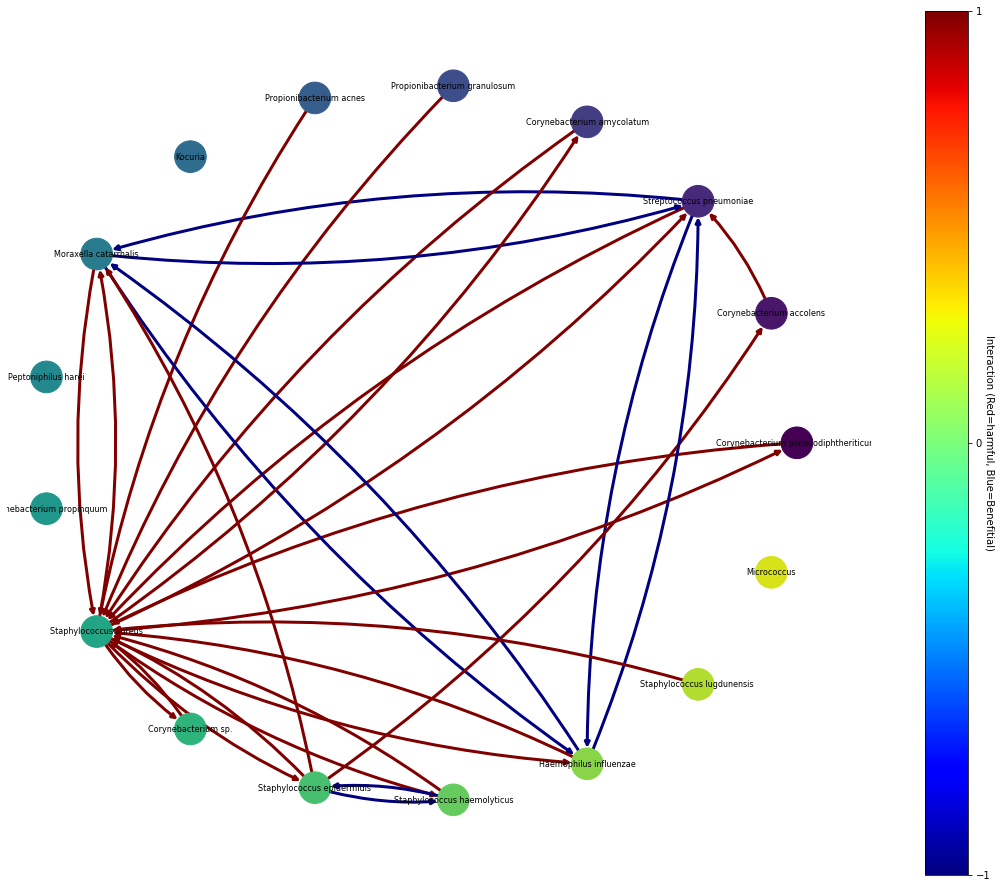

In [133]:
fig = plt.figure(figsize=(15,12))
pos = circular_layout(G)
nx.draw(G, with_labels=True, pos=pos, node_size=1000,
        font_size=8, node_color=colors, edge_color=edge_color, width=3,connectionstyle='arc3, rad = 0.1')
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(-1,1),cmap=cmap2))
cbar.set_label('Interaction (Red=harmful, Blue=Benefitial)', rotation=270)
cbar.set_ticks([-1,0,1])

In [9]:
from ncmw.visualization import plot_species_interaction, plot_reference_interaction, plot_community_interaction

_ = plot_species_interaction(model, df, interaction_cutoff=0.1, alpha=2)

TypeError: plot_species_interaction() got an unexpected keyword argument 'alpha'

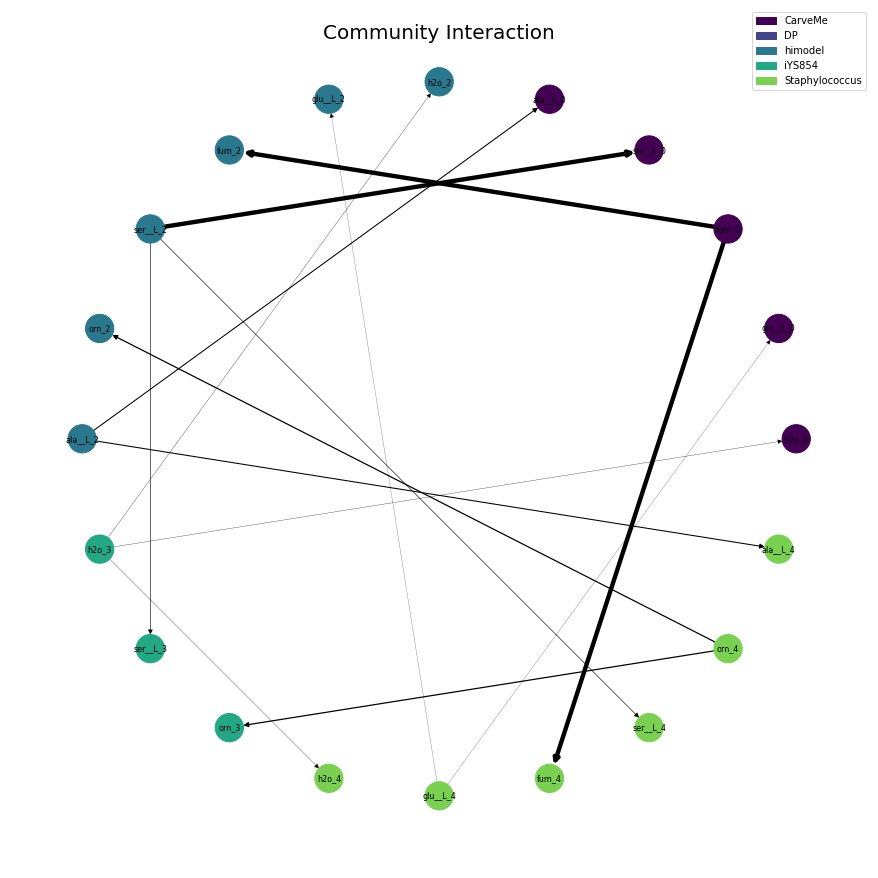

In [8]:
_ = plot_community_interaction(model, df)

In [10]:
model.models

[<Model CarveMe_SNM_gapfilled_model_consistent_snm3 at 0x7fbf254f9700>,
 <Model DP_83VPs_KB5_consistent_snm3 at 0x7fbef26518e0>,
 <Model himodel_consistent_snm3 at 0x7fbeefc805b0>,
 <Model iYS854_consistent_snm3 at 0x7fbeeb1dd970>,
 <Model Staphylococcus_epidermidis_ATCC_12228_consistent_snm3 at 0x7fbeeafea040>]

In [5]:
df = model.summary()

Objective:  2.9587696357643565
CarveMe_SNM_gapfilled_model_consistent_snm3 :  0.14547049040300394  with weights  1.0
DP_83VPs_KB5_consistent_snm3 :  0.0  with weights  1.0
himodel_consistent_snm3 :  0.3687171645760669  with weights  1.0
iYS854_consistent_snm3 :  2.4196099377488944  with weights  1.0
Staphylococcus_epidermidis_ATCC_12228_consistent_snm3 :  0.024972043036391476  with weights  1.0


In [51]:
N = len(model.models)
weights = np.zeros((N,N))
alpha = 1
for i in range(N):
    for j in range(N):
        w_i = model.weights[i]
        w_j = model.weights[j]
        summary_i = df[df.columns[i]]
        summary_j = df[df.columns[j]]
        consumed_j = summary_j < 0
        produced_i = summary_i > 0
        consumed_i = summary_i < 0
        positive_normalizer = 0
        negative_normalizer = 0
        for m in range(N):
            summary_m = df[df.columns[m]]
            produced_m = summary_m > 0
            consumed_m = summary_m < 0
            positive_normalizer += model.weights[m]*produced_m[consumed_j].sum()
            negative_normalizer += model.weights[m]*consumed_m[consumed_j].sum()
        if positive_normalizer != 0:
            weights[i,j] = w_i*produced_i[consumed_j].sum()/positive_normalizer 
        else:
            weights[i,j] = 0
        weights[i,j] *= alpha
        if negative_normalizer != 0:
            weights[i,j] -= w_i*consumed_i[consumed_j].sum()/negative_normalizer
        else:
            weights[i,j]


In [61]:


# Create the colormap using the dictionary
import matplotlib.colors as colors
GnRd = colors.LinearSegmentedColormap.from_list("", ["red", "green"])

In [115]:
import networkx as nx
from networkx.drawing.layout import circular_layout
G = nx.DiGraph()
# Build nodes
import matplotlib
cmap = matplotlib.cm.get_cmap("viridis")
cmap2 = matplotlib.cm.get_cmap("jet")
names = [m.id.split("_")[0] for m in model.models]
G.add_nodes_from(names)

edge_color =[]
colors = [cmap(i/len(names)) for i in range(len(names))]
for i in range(len(model.models)):
    for j in range(len(model.models)):
        if i != j and weights[i,j] != 0:
            n1 = names[i]
            n2 = names[j]
            G.add_edge(n1,n2, weight = weights[i,j])
            edge_color.append(cmap2((-weights[i,j]+1)/2))



In [130]:
weights

array([[-0.30985915,  0.        ,  0.04518072, -0.17808219, -0.02891566],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.36056338,  0.        , -0.36144578,  0.44748858,  0.35903614],
       [ 0.01690141,  0.        ,  0.05722892, -0.35616438, -0.01686747],
       [-0.06760563,  0.        ,  0.25903614,  0.08675799, -0.31325301]])

In [122]:
names

['CarveMe', 'DP', 'himodel', 'iYS854', 'Staphylococcus']

In [117]:
(-weights+1)/2

array([[0.65492958, 0.5       , 0.47740964, 0.5890411 , 0.51445783],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.31971831, 0.5       , 0.68072289, 0.27625571, 0.32048193],
       [0.4915493 , 0.5       , 0.47138554, 0.67808219, 0.50843373],
       [0.53380282, 0.5       , 0.37048193, 0.456621  , 0.65662651]])

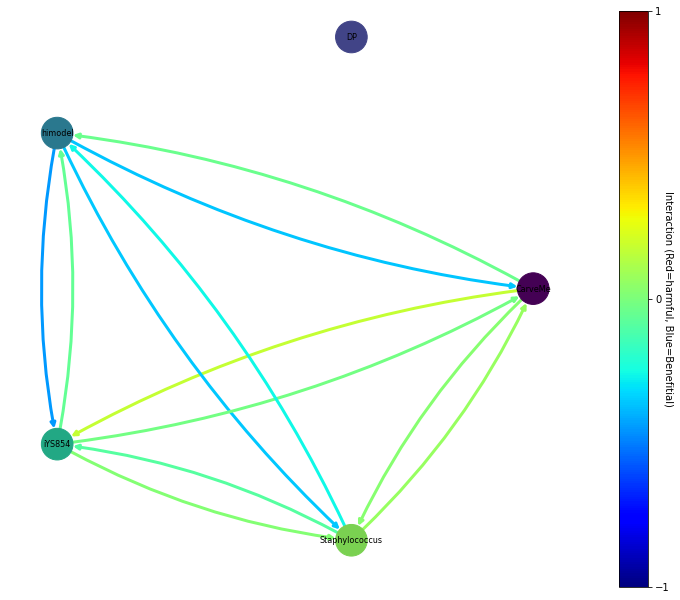

In [144]:
fig = plt.figure(figsize=(10,8))
#plt.title("Shared Uptake", fontsize=30)
nx.draw(G, with_labels=True, pos=pos, node_size=1000,
        font_size=8, node_color=colors, edge_color=edge_color, width=3,connectionstyle='arc3, rad = 0.1')
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(-1,1),cmap=cmap2))
cbar.set_label('Interaction (Red=harmful, Blue=Benefitial)', rotation=270)
cbar.set_ticks([-1,0,1])

In [20]:
postive_interaction.sum(1)

array([2., 0., 8., 3., 4.])

In [18]:
postive_interaction

array([[0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0.],
       [3., 0., 0., 2., 3.],
       [1., 0., 1., 0., 1.],
       [1., 0., 2., 1., 0.]])

Objective:  2.9587696357643565
CarveMe_SNM_gapfilled_model_consistent_snm3 :  0.14547049040300394  with weights  1.0
DP_83VPs_KB5_consistent_snm3 :  0.0  with weights  1.0
himodel_consistent_snm3 :  0.3687171645760669  with weights  1.0
iYS854_consistent_snm3 :  2.4196099377488944  with weights  1.0
Staphylococcus_epidermidis_ATCC_12228_consistent_snm3 :  0.024972043036391476  with weights  1.0


/home/manu/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


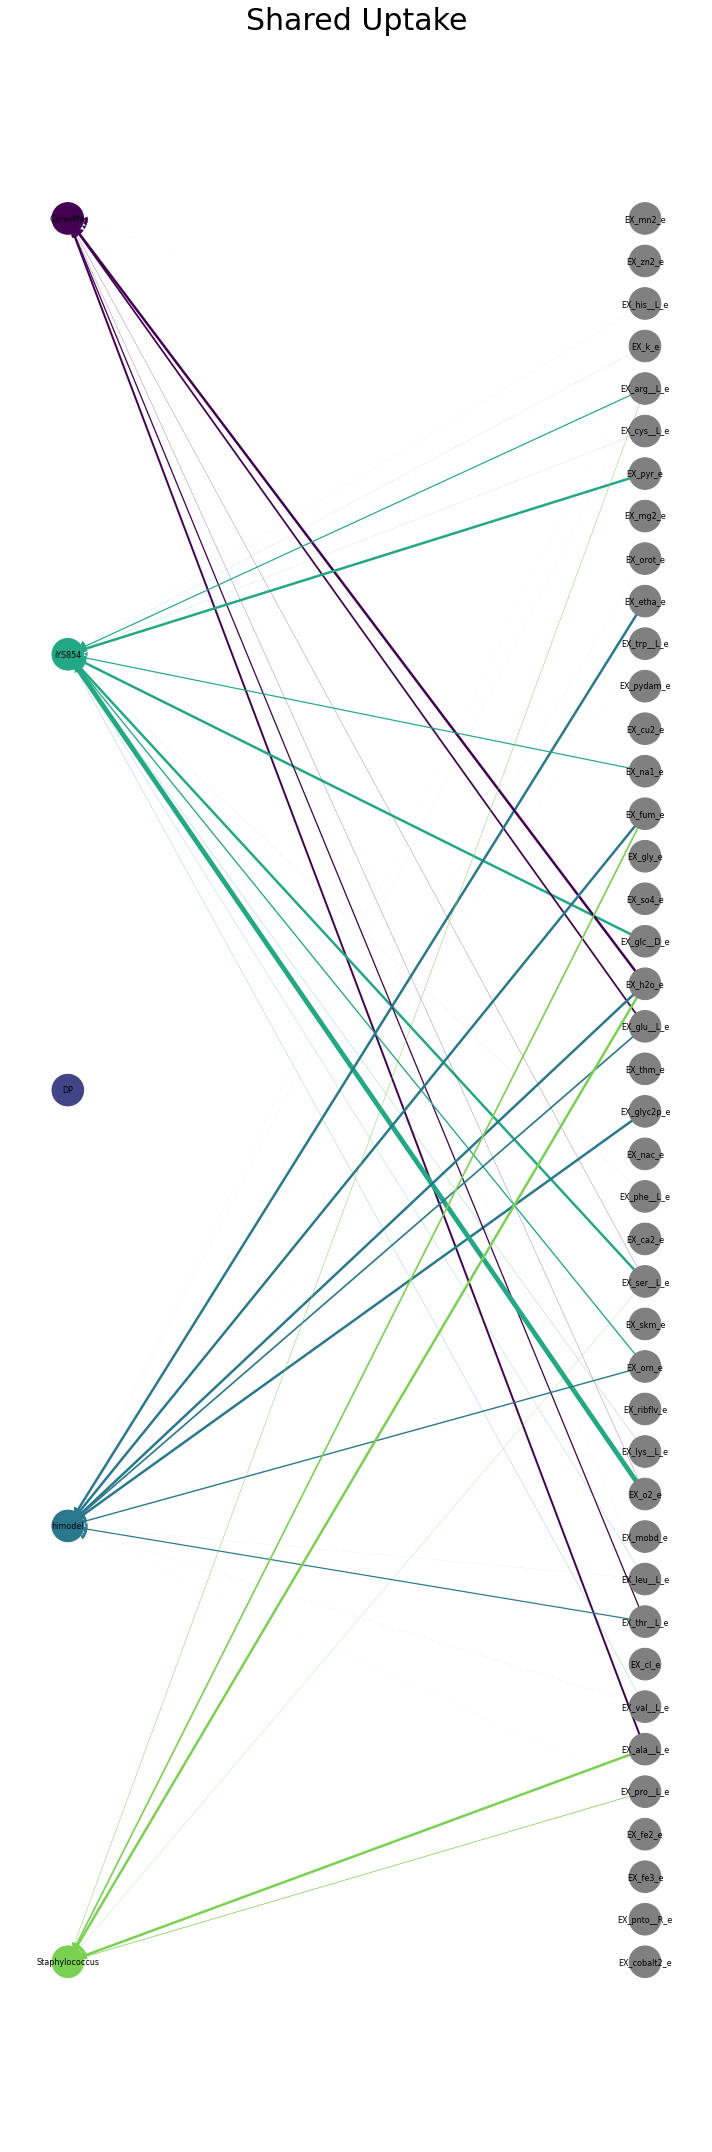

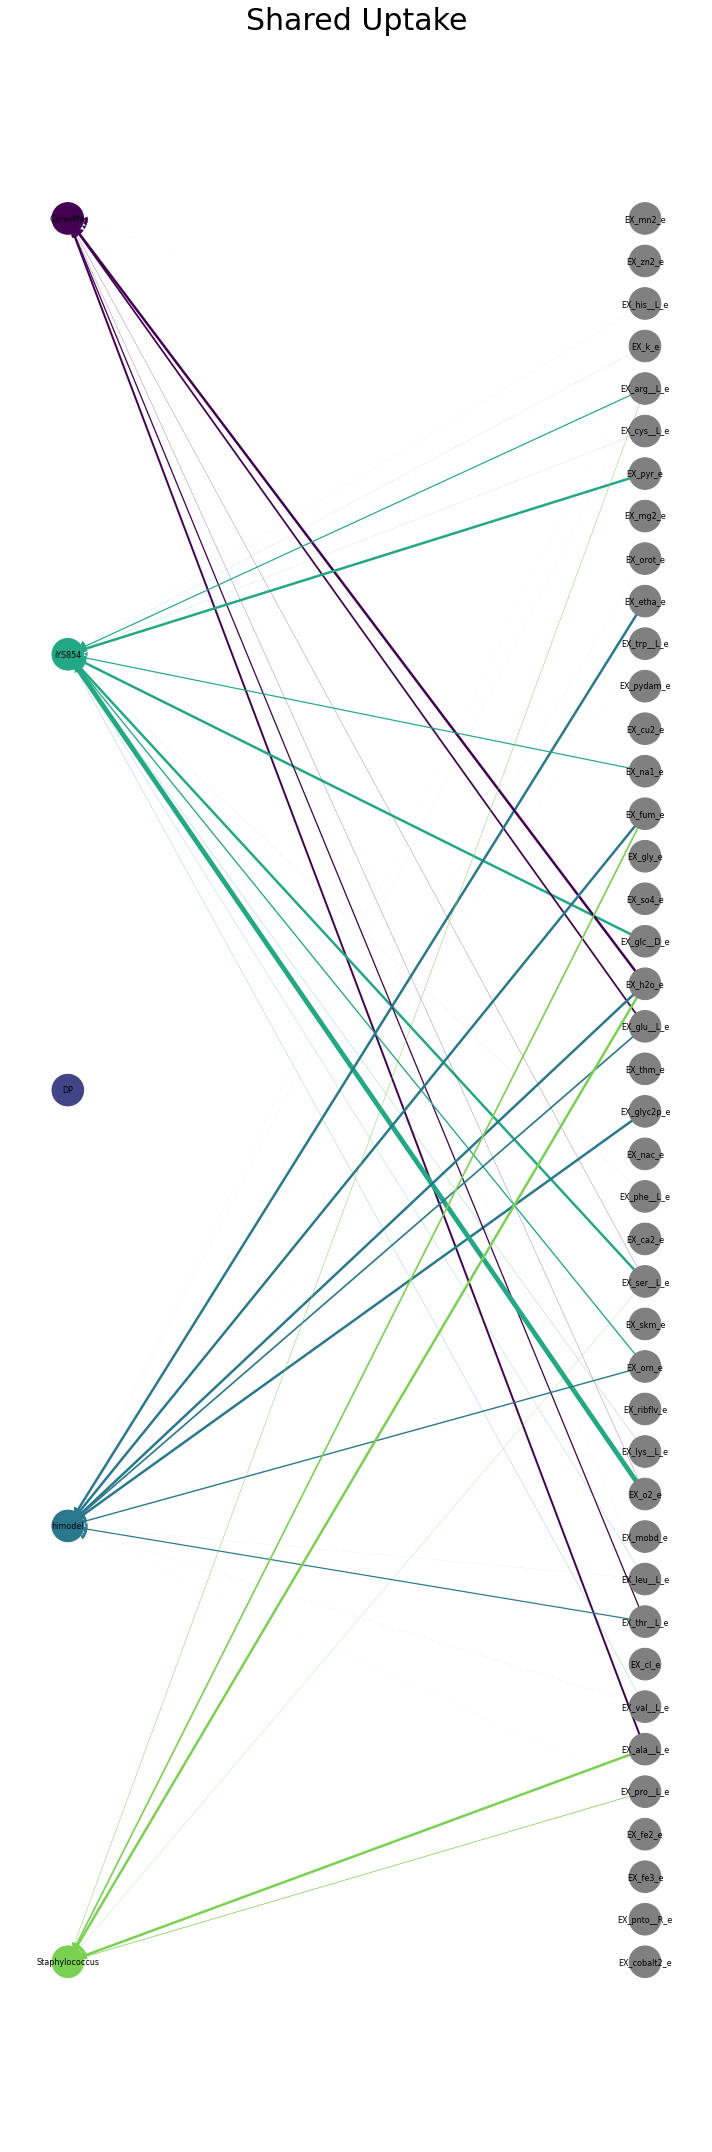

In [5]:
plot_community_uptake_graph(model, model.summary())

In [59]:
df = model.summary()
df.head()

Objective:  2.9587696357643565
CarveMe_SNM_gapfilled_model_consistent_snm3 :  0.14547049040300394  with weights  1.0
DP_83VPs_KB5_consistent_snm3 :  0.0  with weights  1.0
himodel_consistent_snm3 :  0.3687171645760669  with weights  1.0
iYS854_consistent_snm3 :  2.4196099377488944  with weights  1.0
Staphylococcus_epidermidis_ATCC_12228_consistent_snm3 :  0.024972043036391476  with weights  1.0


,CarveMe_SNM_gapfilled_model_consistent_snm3,DP_83VPs_KB5_consistent_snm3,himodel_consistent_snm3,iYS854_consistent_snm3,Staphylococcus_epidermidis_ATCC_12228_consistent_snm3,Shuttle Reaction
EX_cys__L_e,0.00000,0.0,0.00000,-0.43628,0.00000,-0.43628
EX_ribflv_e,0.00000,0.0,0.00000,-0.00072,-0.00001,-0.00073
EX_fum_e,6.75017,0.0,-10.00000,0.00000,-6.75017,-10.00000
EX_etoh_e,5.07323,0.0,14.68235,1.39290,0.00000,21.14849
EX_lys__L_e,-0.04995,0.0,0.00000,-0.87221,-0.00830,-0.93046


In [66]:
names = np.array([m.id.split("_")[0] for m in models])
df_in = df["Shuttle Reaction"]
shared_output = dict()
for i, data in df.iterrows():
    data = data[:-1]
    x = data.to_numpy()
    y = df_in[i]
    if y < 0:
        inputs = x < 0
        input_names = names[inputs]
        fluxes = x[inputs]
        if inputs.sum() > 0:
            shared_output[i] = (input_names, fluxes)
    

In [80]:
import networkx as nx
from networkx.drawing.layout import bipartite_layout

In [130]:
import networkx as nx
from networkx.drawing.layout import bipartite_layout
G = nx.DiGraph()
# Build nodes
import matplotlib
cmap = matplotlib.cm.get_cmap("viridis")
G.add_nodes_from(names)
G.add_nodes_from(list(shared_output.keys()))
colors = [cmap(i/len(names)) for i in range(len(names))] + ["Grey"]*len(shared_output)
widths = []
edge_color = []
for ex, (name, f) in shared_output.items():
    for i in range(len(name)):
        n = name[i]
        flux = f[i]
        G.add_edge(ex,n, weight=flux)
        widths.append(flux/4)
        edge_color.append(cmap(np.argmax(names == n)/len(names)))


In [134]:
len([10000, 10000, 10000,10000,10000,10000, 10000, 10000,10000,10000, 10000, 10000, 10000,10000,10000,10000, 10000, 10000,10000,10000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

30

In [135]:
import subprocess
subprocess.run(["scancel", "-n","run_one.sh"])

FileNotFoundError: [Errno 2] No such file or directory: 'scancel'

In [131]:
pos = bipartite_layout(G, names)

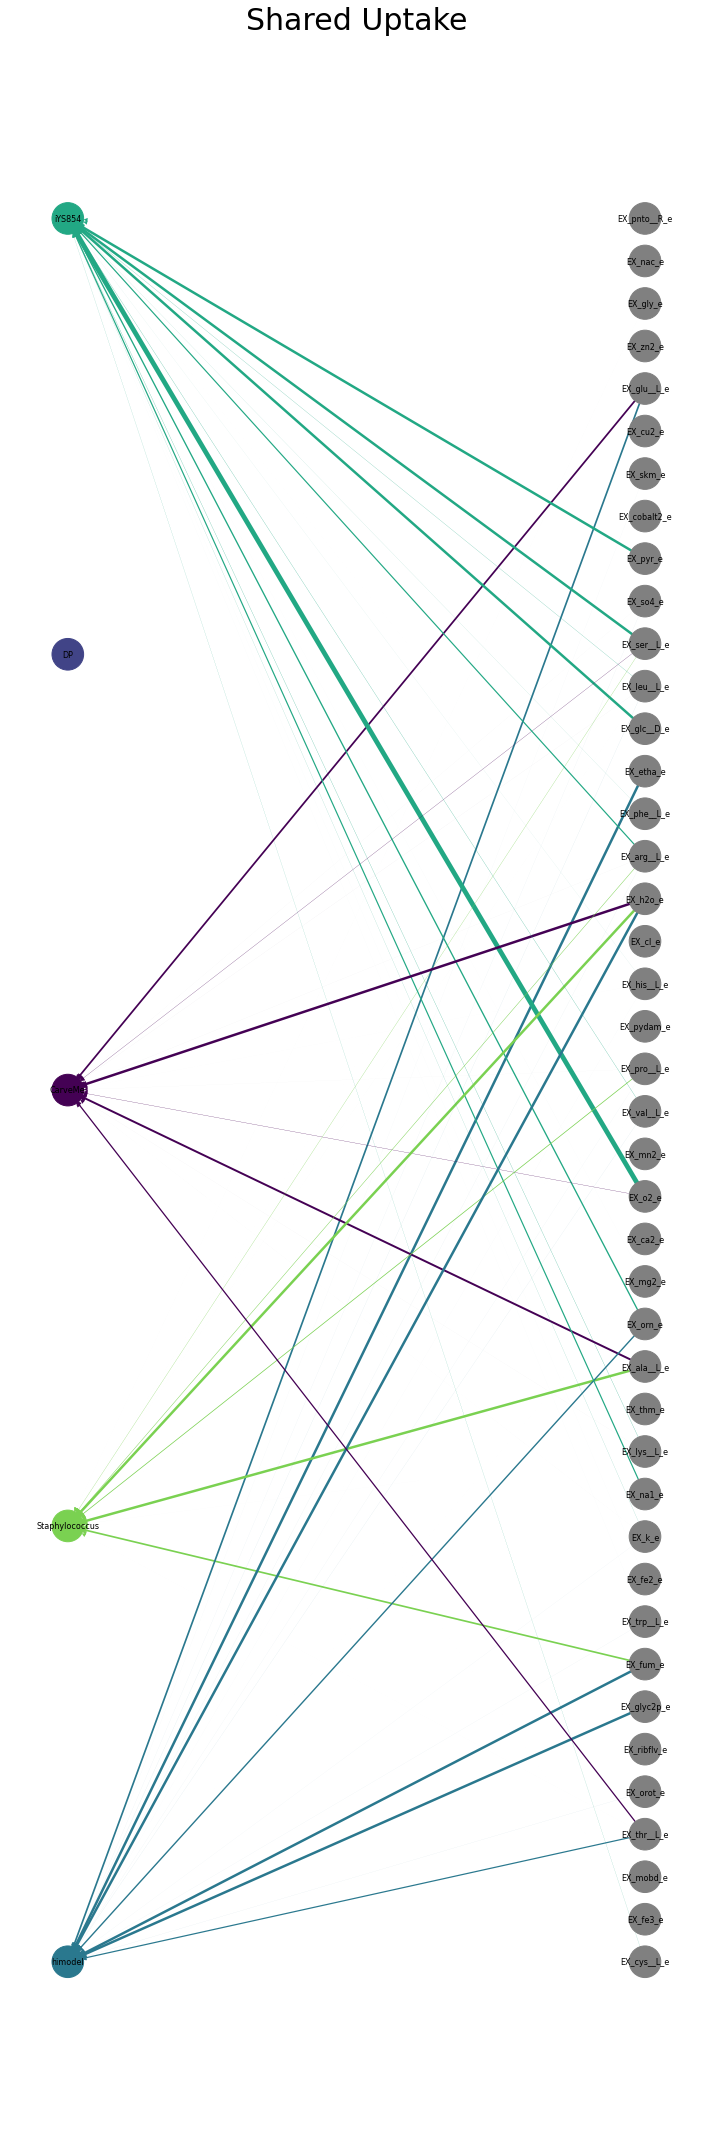

In [132]:
plt.figure(figsize=(10,30))
plt.title("Shared Uptake", fontsize=30)
nx.draw(G, with_labels=True, pos=pos, node_size=1000,
        font_size=8, width=widths, node_color=colors, edge_color=edge_color)
plt.tight_layout()

In [67]:
shared_output

{'EX_cys__L_e': (array(['iYS854'], dtype='<U14'), array([-0.43628])),
 'EX_ribflv_e': (array(['iYS854', 'Staphylococcus'], dtype='<U14'),
  array([-7.2e-04, -1.0e-05])),
 'EX_fum_e': (array(['himodel', 'Staphylococcus'], dtype='<U14'),
  array([-10.     ,  -6.75017])),
 'EX_lys__L_e': (array(['CarveMe', 'iYS854', 'Staphylococcus'], dtype='<U14'),
  array([-0.04995, -0.87221, -0.0083 ])),
 'EX_ca2_e': (array(['CarveMe', 'himodel', 'Staphylococcus'], dtype='<U14'),
  array([-0.00076, -0.00186, -0.00013])),
 'EX_pydam_e': (array(['himodel'], dtype='<U14'), array([-8.e-05])),
 'EX_cl_e': (array(['CarveMe', 'himodel', 'iYS854', 'Staphylococcus'], dtype='<U14'),
  array([-0.00076, -0.00186, -0.01198, -0.00013])),
 'EX_etha_e': (array(['himodel'], dtype='<U14'), array([-10.])),
 'EX_glu__L_e': (array(['CarveMe', 'himodel'], dtype='<U14'),
  array([-7.01177, -6.77133])),
 'EX_zn2_e': (array(['CarveMe', 'himodel', 'iYS854', 'Staphylococcus'], dtype='<U14'),
  array([-5.0e-05, -1.2e-04, -7.8e-04

In [19]:
df_help = df[df.columns[:-1]]
medium_col = np.zeros(len(df_help))
for i, ex in enumerate(df_help.index):
    if ex in model.medium:
        medium_col[i] = model.medium[ex]
    else:
        medium_col[i] = 0.0
# Set output to zero
help_array = df_help.to_numpy()
help_array[help_array >= 0] = 0
# Non medium associated inputs -> interactions !
species_interaction = (help_array.sum(1) + medium_col) < -1e-6
species_interaction
df = df[species_interaction]
df = df.drop("Shuttle Reaction", 1)

In [21]:
df

,CarveMe_SNM_gapfilled_model_consistent_snm3,DP_83VPs_KB5_consistent_snm3,himodel_consistent_snm3,iYS854_consistent_snm3,Staphylococcus_epidermidis_ATCC_12228_consistent_snm3
EX_fum_e,6.75017,0.0,-10.00000,0.00000,-6.75017
EX_glu__L_e,-7.01177,0.0,-6.77133,0.00000,3.78311
EX_ala__L_e,-7.89701,0.0,7.89701,0.00000,-10.00000
EX_orn_e,0.00000,0.0,-5.59837,-5.31666,0.91503
EX_ser__L_e,-0.89463,0.0,1.84989,-10.00000,-0.95526
EX_h2o_e,-10.00000,0.0,-10.00000,28.10631,-10.00000


Objective:  2.9587696357643565
CarveMe_SNM_gapfilled_model_consistent_snm3 :  0.14547049040300394  with weights  1.0
DP_83VPs_KB5_consistent_snm3 :  0.0  with weights  1.0
himodel_consistent_snm3 :  0.3687171645760669  with weights  1.0
iYS854_consistent_snm3 :  2.4196099377488944  with weights  1.0
Staphylococcus_epidermidis_ATCC_12228_consistent_snm3 :  0.024972043036391476  with weights  1.0


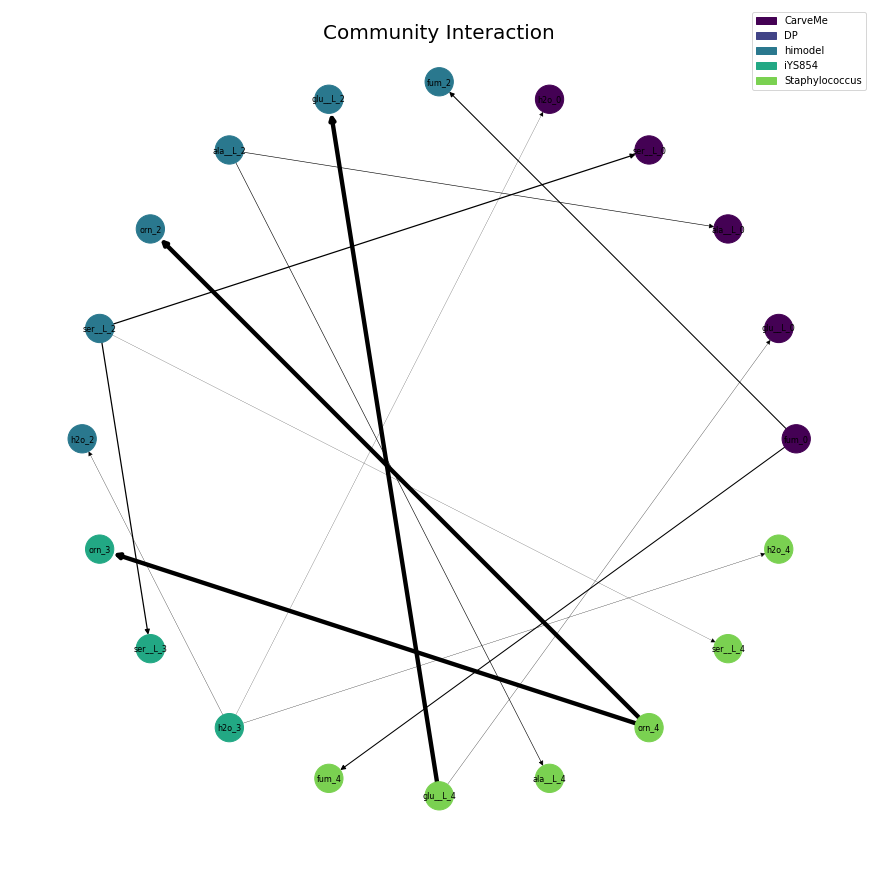

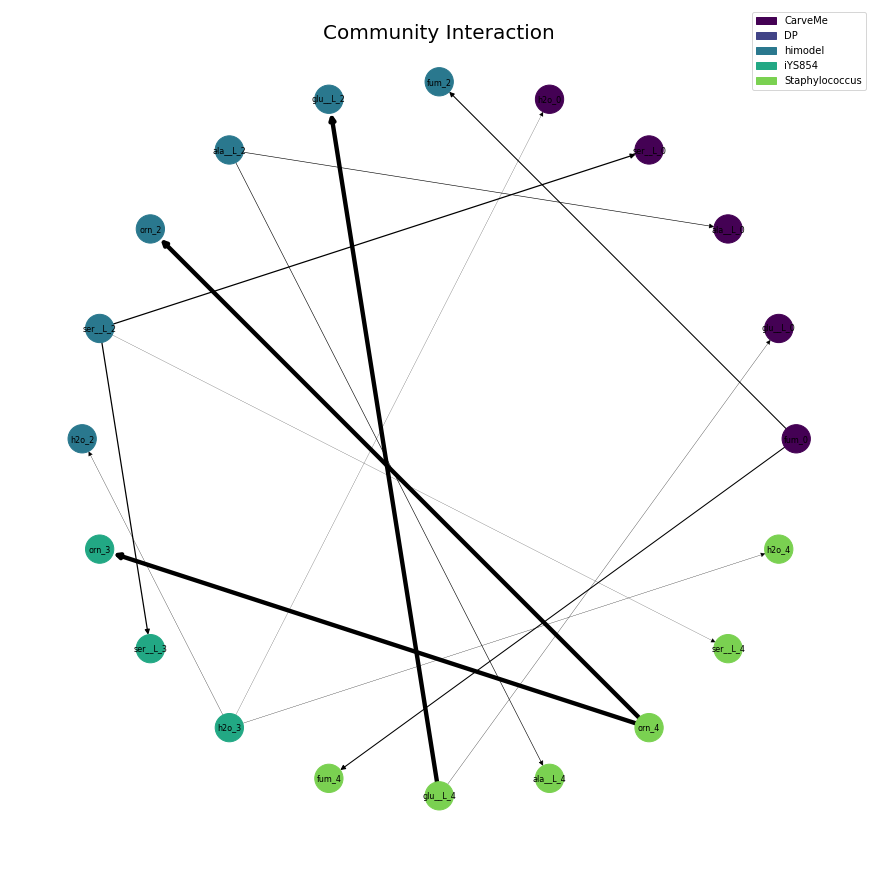

In [22]:
plot_community_interaction(model, model.summary())

In [ ]:
coopm = model.computeCOOPM(model.slim_optimize())
model.medium = coopm 
plot_community_interaction(model, model.summary())

In [ ]:
plot_pairwise_growth_relation_per_weight(model)

In [ ]:
medium = dict([(key, val) for key, val in snm3.items() if key in [ex.id for ex in models[0].exchanges]])

In [ ]:
m3 =  read_sbml_model("data/gapfill_baseline/iJN1463.xml")

In [ ]:
fill_model = fill_model + m3

In [ ]:
from cobra.io import read_sbml_model
fill_model = read_sbml_model("data/gapfill_baseline/model.xml")
m = read_sbml_model("data/gapfill_baseline/iAF1260.xml")
fill_model = fill_model + m

In [ ]:
models[0].medium = medium 
gapfill_model(models[0], fill_model_base=fill_model)

In [ ]:
models[0].medium = medium 
m, rec = gapfill_medium(models[0])
rec

In [ ]:
list(models[0].metabolites.get_by_id("fe3dcit_p").reactions)[1]

In [ ]:
for r in rec:
    model = deepcopy(models[0])
    model.medium = medium
    objective = model.reactions.get_by_id(r).flux_expression
    model.objective = objective
    model , sol = gapfill_model(model)
    print(sol)

In [ ]:
model = models[0]
model.reactions.get_by_id("EX_fe3dcit_e")
from cobra import Reaction
reaction = Reaction("SK_fe3dcit_e")
reaction.lower_bound = -0.1
reaction.upper_bound = 1000 
model.add_reaction(reaction)
reaction.add_metabolites({"fe3dcit_e":-1.0})
reaction

In [ ]:
models[0].optimize()

In [ ]:
cobra.io.read_sbml_model()

In [ ]:
model.optimize()

In [ ]:
model.reactions.get_by_id(rec[2]).flux

In [ ]:
model.optimize()

In [ ]:
model, rec = gapfill_model(models[0], eps=0.05)

In [ ]:
model.optimize()

In [ ]:
models[0].reactions.Growth.flux

In [ ]:
model.optimize()

In [ ]:
from sbi.analysis import pairplot

In [ ]:
model = BagOfReactionsModel(models)

In [ ]:
model = ShuttleCommunityModel(models)
N = len(model.models)

In [ ]:
model.compute_convex_combination([0.25,0.25, 0.25,0.25], maxbiomass=0.1)

In [ ]:
df = model.summary()
plot_community_interaction(model, df)

In [ ]:
import torch
N = len(model.models)
def simulator(thetas):
    xs = []
    for weight in thetas:
        model.weights = weight.numpy()
        growths = torch.tensor(model.optimize()[-1])
        xs.append(growths)
    return torch.vstack(xs)

prior = torch.distributions.Dirichlet(torch.ones(N))
prior.set_default_validate_args(False)

thetas = prior.sample((5000,))
xs = simulator(thetas)


In [ ]:
from sbi.inference import SNLE

inf = SNLE(prior)
density_estimator = inf.append_simulations(thetas, xs).train()

In [ ]:
x_o = torch.tensor([0.1,0.1,0,0.1,0.1])
posterior = inf.build_posterior(density_estimator, sample_with="vi", vi_parameters={"flow":"spline_autoregressive", "bound":15, "num_bins":15})
posterior.set_default_x(x_o)

In [ ]:
posterior.train(loss="elbo", max_num_iters=500)

In [ ]:
samples = posterior.sample((10000,))
fig, axes = pairplot(samples, labels=["Weights: "+m.id.split("_")[0] for m in model.models])
fig.suptitle(f"Observed Growth: {[np.round(float(x),4) for x in x_o]}", fontsize=15)

In [ ]:
x_o = torch.tensor(xs[0])
posterior = inf.build_posterior(density_estimator, sample_with="vi", vi_parameters={"flow":"spline_autoregressive", "bound":15, "num_bins":15})
posterior.set_default_x(x_o)
posterior.train(loss="elbo", max_num_iters=500)

In [ ]:
samples = posterior.sample((10000,))
fig, axes = pairplot(samples, labels=["Weights: "+m.id.split("_")[0] for m in model.models])
fig.suptitle(f"Observed Growth: {[np.round(float(x),4) for x in x_o]}", fontsize=15)

In [ ]:
simulator(samples[:1000]).mean(0)

In [ ]:
from scipy.optimize import least_squares, LinearConstraint, minimize
constraint1 = LinearConstraint(np.ones(N).reshape(-1,1).T, 1,1)
constraint2 = LinearConstraint(np.eye(N).T, 0,1)
def f(weight):
    model.weights = weight
    growth = np.array(model.slim_optimize())
    if growth is None:
        growth=0
    return -1*growth

In [ ]:
minimize(f, np.random.dirichlet(10*np.ones(N)), constraints=[constraint1,constraint2], method="SLSQP")

In [ ]:
N = len(model.models)
growth_dict = dict()
for i in range(N):
    for j in range(i+1, N):
        alphas, growth1, growth2 = compute_pairwise_growth_relation_per_weight(model,i,j)
        growth_dict[(i,j)] = (growth1, growth2)
        growth_dict[(j,i)] = (growth2, growth1)

In [ ]:
fig, axes = plt.subplots(N-1, N-1, figsize=(15,15), sharey=True)
for i in range(len(axes)):
    axes[i,i].set_xlabel(r"$\alpha$ weight" )
    axes[i,i].yaxis.set_tick_params(labelleft=True)
    for j in range(i+1,len(axes[i])+1):
        axes[0,j-1].set_title(model.models[j].id.split("_")[0] + "\n", fontsize=20)
        if j == i+1:
            axes[i,-1].set_ylabel("\n" + (model.models[i].id.split("_")[0]), fontsize=20)
            axes[i,-1].yaxis.set_label_position("right")
            ax2 = axes[i,j-1].twinx() 
            ax2.set_ylabel("Growth \n \n")
            ax2.yaxis.set_label_position("left")
            ax2.set_yticklabels([])
            ax2.set_yticks([])
        growth1, growth2 = growth_dict[(i,j)]
        axes[i,j-1].plot(alphas, growth1, color="black")
        axes[i,j-1].plot(alphas, growth2, color="black", linestyle=":")
        if j < N -1:
            axes[j,i].axis("off")
fig.tight_layout()


In [ ]:
import seaborn as sns
penguins = sns.load_dataset("penguins")
g = sns.PairGrid(penguins, diag_sharey=False, corner=True)
g.map_lower(sns.pointplot)
g.map_diag(sns.kdeplot)

In [ ]:
penguins

In [ ]:
plt.plot(alphas, growth1)
plt.plot(alphas, growth2)

In [ ]:
weights = compute_fair_weights(model)
model.weights = weights

In [ ]:
coopm = model.computeCOOPM(model.slim_optimize(), fraction=0.1)

In [ ]:
_ = plot_community_interaction(model, model.summary())

In [ ]:
model.medium = coopm
_ = plot_community_interaction(model, model.summary())

In [ ]:
model.medium = coopm
df = model.summary()

In [ ]:
df

In [ ]:
medium_col

In [ ]:
df_help = df[df.columns[:-1]]
medium_col = np.zeros(len(df_help))
for i,ex in enumerate(df_help.index):
    if ex in model.medium:
        medium_col[i] = model.medium[ex]
    else:
        medium_col[i] = 0.
# Set output to zero
help_array = df_help.to_numpy()
help_array[help_array >= 0] = 0
species_interaction = (help_array.sum(1) + medium_col) < -1e-6
species_interaction

df = df[species_interaction]
df = df.drop("Shuttle Reaction", 1)

In [ ]:
import matplotlib
G = nx.DiGraph()

cmap = matplotlib.cm.get_cmap('Spectral')
# Build nodes
for i,col in enumerate(df.columns):
    names = [n[3:-2] + f"_{i}" for n in df[df[col] != 0].index]
    G.add_nodes_from(names)
colors = []
for n in G.nodes:
    i = int(n[-1])
    G.nodes[n]["class"] = model.models[i].id.split("_")[0]
    colors.append(cmap(i/len(model.models)))


# Build edges
linewidths = []
for ex, data in df.iterrows():
    idx = np.arange(len(df.columns))
    data = np.array(data)
    producer = idx[data > 0]
    consumer = idx[data < 0]
    for p in producer:
        node1 = ex[3:-2] + f"_{p}"
        for c in consumer:
            node2 = ex[3:-2] + f"_{c}"
            G.add_edge(node1,node2, weight=data[p])
            linewidths.append(data[p])
    

In [ ]:
widths = np.array(linewidths)
widths /= widths.sum()
widths[widths < 0.01] = 0.01

In [ ]:
[matplotlib.patches.Patch(label=m.id.split("_")[0], color=colors[i]) for i,m in enumerate(model.models)][0]

In [ ]:
from networkx.drawing.layout import circular_layout
fig = plt.figure(figsize=(10,10))
pos = circular_layout(G, scale=1, center=None, dim=2)
nx.draw(G, pos=pos, with_labels=True, node_size=800, font_size=8, node_color=colors, width=widths*20)
pathes = []
for i in range(len(model.models)):
    pathes.append(matplotlib.patches.Patch(color=cmap(i/len(model.models)),label=model.models[i].id.split("_")[0]))
fig.suptitle("Community Interaction", fontsize=20)
plt.legend(handles=pathes)

In [ ]:
from nxviz import annotate
import nxviz as nv 
fig = plt.figure(figsize=(20,20))
c = nv.api.CircosPlot(
    G,
    node_grouping="class",
    node_color="class",
    edge_width="weight",
    edge_alpha="weight"
)
annotate.circos_group(G, group_by="class")

In [ ]:
c.fig.figsi

In [ ]:
model_col = []
reaction_col = []
flux_col = []
for col in df.columns[:-1]:
    model_list = [col]*len(df)
    model_col += model_list 
    reaction_col += df.index.tolist()
    flux_col += df[col].tolist()
df2 = pd.DataFrame({"Model": model_col, "Reaction": reaction_col, "Flux": flux_col})
# Drop all zero fluxes
df2 = df2[df2["Flux"] != 0]

In [ ]:
from random import choice

import matplotlib.pyplot as plt
import networkx as nx

from nxviz import circos

G = nx.DiGraph()
G.add_nodes_from([0,1,2,3,4,5,6,7,8])
G.add_edges_from([(0,1), (1,4), (4,8), (8,4), (4,7)])
for n, d in G.nodes(data=True):
    G.nodes[n]["class"] = choice(["a", "b", "c", "d", "e"])
for e in G.edges:
    G.edges[e]["class"] = choice(["ab", "cd"])
c = circos(
    G,
    group_by="class",
    node_color_by="class",
    edge_color_by="class",

)
plt.show()

In [ ]:
nx.draw(G)

In [ ]:
g.nodes["TPH1"]

In [ ]:
import nxviz as nv
ax = nv.circos(
    G,
    group_by="group",
    edge_alpha_by="weight"
)

In [ ]:
model.computeCOOPM(MBR[0], enforce_survival=True)

In [ ]:
COOPMS_enforced = dict()
for m, compm, weight in zip([model], [model.medium.copy()], [[[1,1,1]] + compute_dominant_weights(model)]):
    for w in weight:
        print(w)
        m.medium = compm
        m.weights = np.array(w)
        MBR = m.slim_optimize()
        print(MBR)
        if MBR is None:
            MBR = 0
        coopm = m.computeCOOPM(MBR)
        if tuple(w) in COOPMS_enforced:
            COOPMS_enforced[tuple(w)].append(coopm)
        else:
            COOPMS_enforced[tuple(w)] = [coopm]


In [ ]:
model.medium = compm 
model.slim_optimize()

In [ ]:
COOPMS_enforced.values()

In [ ]:
import pandas as pd
df = pd.concat(fvas)
df = df.groupby(df.index).min()
mediums = []
for model in models:
    medium = model.medium
    for key in medium:
        if key in df.index:
            flux = df.loc[key].minimum
            medium[key] = -flux
    mediums.append(medium)

In [ ]:
df1, df2, df3 = jaccard_similarity_matrices(models)

In [ ]:
df1

In [ ]:
jaccard_similarity(models[0], models[1])

In [ ]:
models[2].slim_optimize()

In [ ]:
models[0].reactions[0]

In [ ]:
model = ShuttleCommunityModel(models)

In [ ]:
model.optimize()

In [ ]:
model._open_exchanges_for_shuttles(-10)

In [ ]:
model.weights = [1,1,1]
model.optimize()

In [ ]:
model.summary()

In [ ]:
model.weights = [1,1,0.3]
model.optimize()

In [ ]:
model.summary()

In [ ]:
model.optimize()

In [ ]:
model = models[0]
exchanges = [ex.id for ex in model.exchanges]
model.medium = dict(
        [(key, val) for key, val in get_default_medium().items() if key in exchanges]
    )

In [ ]:
    eps=1e-1
    model_help = model.copy()
    # if model_help.slim_optimize() > eps:
    #     # Already feasible model.
    #     return model, []
    # We can gapfill any exchange reaction that currently is not in the medium
    gapfillable = set([ex.id for ex in model_help.exchanges]).difference(
        set(model.medium.keys())
    )
    print(f"There are {len(gapfillable)} many metabolites to fill the medium")

    biomass = get_biomass_reaction(model_help)
    # Binary variables: Theta_i
    # This is an indicator which is zero if the metabolite should be added to the medium
    thetas = []
    for i in range(len(gapfillable)):
        thetas.append(model_help.problem.Variable("theta_" + str(i), type="binary"))

    # Constraints for exchanges, which are turned of for theta_i = 1
    theta_constraints = []
    for i, id in enumerate(gapfillable):
        reaction = model_help.reactions.get_by_id(id)
        min_bound = -10
        reaction.lower_bound = min_bound
        cons = model_help.problem.Constraint(
            (reaction.flux_expression + min_bound * thetas[i]), lb=min_bound, ub=1000
        )
        theta_constraints.append(cons)

    # Constraints for growth rates, which must be at least 10% MBR
    constraint_growth = model_help.problem.Constraint(
        biomass.flux_expression, lb=eps, ub=1000
    )

    # Adding new variables and constraints.
    model_help.add_cons_vars(thetas)
    model_help.add_cons_vars(theta_constraints)
    model_help.add_cons_vars(constraint_growth)

    # Objevtive is maximising turned of exchanges, that is sum of theta_is
    objective = model_help.problem.Objective(sum(thetas), direction="max")
    model_help.objective = objective
    model_help.solver.update()

    # Model optimization
    sol = model_help.optimize()
    new_exchanges = [
        ex.id
        for ex in model_help.exchanges
        if ex.flux < 0 and ex.id not in model.medium
    ]
    new_exchanges

    extended_medium = model.medium
    for id in new_exchanges:
        extended_medium[id] = 10
    model.medium = extended_medium

In [ ]:
import cobrababel 
model = cobrababel.create_bigg_universal_model()

In [ ]:
get_models("gapfill_baseline")

In [ ]:
gapfill_medium(model)[0].optimize()

In [ ]:
import cobra 
import numpy as np 
import scipy 

from mip import xsum, maximize, BINARY
import mip

from abc import ABC, abstractmethod, abstractproperty
import typing

import sys, os
import tempfile

import pickle

import pandas as pd

def create_stoichiometry_matrix(model):
    """ This creates a stoichiometry matrix"""
    metabolites = model.metabolites 
    reactions = model.reactions 
    S = np.zeros((len(metabolites), len(reactions)))
    
    met_id = dict()
    rec_id = dict()
    for i,reaction in enumerate(model.reactions):
        rec_id[reaction.id] = i
        for metabolite, stoich in reaction.metabolites.items():
            met_id[metabolite.id] = int(metabolites.index(metabolite))
            S[metabolites.index(metabolite), i] = stoich
    # Compress as sparse matrix
    S = scipy.sparse.csr_matrix(S)
    return S, met_id, rec_id 

def get_biomass_reaction(model):
    """ Return the biomass reaction of a model """
    objective_str = str(list(model.objective.variables)[0])
    for rec in model.reactions:
        if rec.id in objective_str:
            return rec

class CommunityModel(ABC):
    """This gives the backbone of any community model.
    """
    @property
    def medium(self):
        return self._medium 

    @medium.setter
    def medium(self, medium):
        return self._set_medium(medium)
    
    @abstractmethod
    def _set_medium(self, medium):
        """ This method should set the medium properly"""
        pass

    @property
    def weights(self):
        return self._weights

    @weights.setter
    def weights(self, weights):
        return self._set_weights(weights)
    
    @abstractmethod
    def _set_weights(self, weights):
        """ This method should set the weights properly"""
        pass

    @abstractmethod
    def slim_optimize(self):
        """ This method returns the current objective value"""
        pass

    @abstractmethod
    def single_optimize(self, idx):
        """ This method returns the current objective value"""
        pass
    
    @abstractmethod
    def optimize(self):
        """ This method return the current objective value and additional information """
        pass

    def computeCOOPM(self, MBR, fraction=0.1, enforce_survival=True):
        """ This method computes the COOPM medium """
        raise NotImplementedError("This method is not implemented fro your current model")

    def summary(self):
        """ This method should report a summary of the model"""
        raise NotImplementedError("This method is not implemented for your current model")

    def save(self, path):
        """ This saves the model using pickle. For other format overwrite this function"""
        with open(path + ".pkl","wb+") as f:
            pickle.dump(self,f)
    def load(self, path):
        with open(path + ".pkl","wb") as f:
            self = pickle.load(f)


class BagOfReactionsModel(CommunityModel):
    """This is a community model, which treats the community as a bag of all reactions that at least one the species has. 
    """
    def __init__(self, models:list):
        self.community_model = cobra.Model("Community__" + "".join([model.id + "__" for model in models]))
        for model in models:
            self.community_model += model
        self.models = models
        self._weights = np.ones(len(models))
        self._medium = self.community_model.medium
        self.biomass_reactions = [get_biomass_reaction(model) for model in models]
        self.objective = sum([f.flux_expression for f in self.biomass_reactions])
        self.community_model.objective = self.objective

    def _set_medium(self, medium):
        self.community_model.medium = medium 
        self._medium = medium 

    def _set_weights(self, weights):
        assert len(weights) == len(self.models), "You need to specify for each species in the community a weights..."
        self._weights = weights 
        self.objective = sum([weights[i]*self.biomass_reactions[i].flux_expression for i in range(len(self.weights))])
        self.community_model.objective = self.objective

    def slim_optimize(self):
        return self.community_model.slim_optimize()

    def optimize(self):
        sol = self.community_model.optimize()
        total_growth = self.community_model.slim_optimize()
        single_growths = [sol[r.id] for r in self.biomass_reactions]
        return total_growth, single_growths

    def single_optimize(self, idx):
        weights = np.zeros(len(self.models))
        weights[idx] = 1. 
        old_weights = self._weights
        self._set_weights(weights)
        growth = self.slim_optimize()
        self._set_weights(old_weights)

        return growth

    def summary(self):
        return self.community_model.summary()

    def computeCOOPM(self, MBR, fraction=0.1, enforce_survival=True):
        model = self.community_model.copy()
        minMBR = fraction*MBR
        medium = list(model.medium.keys())
        biomass = [model.reactions.get_by_id(f.id).flux_expression for f in self.biomass_reactions]

        # Binary variables: Theta_i 
        thetas = []
        for i in range(len(medium)):
            thetas.append(model.problem.Variable('theta_'+str(i), type="binary"))

        # Constraints for exchanges, which are turned of for theta_i = 1
        theta_constraints = []
        for i,id in enumerate(medium):
            reaction = model.reactions.get_by_id(id)
            min_bound = model.reactions.get_by_id(id).lower_bound
            cons = model.problem.Constraint(
                (reaction.flux_expression + min_bound*thetas[i]),
                lb=min_bound,
                ub=1000)
            theta_constraints.append(cons)

        # Constraints for growth rates, which must be at least 10% MBR
        if enforce_survival:
            constraint_growth = [model.problem.Constraint(
            f,
            lb=self.weights[i]*minMBR,
            ub=1000) for i,f in enumerate(biomass)]
        else:
            constraint_growth = model.problem.Constraint(
            sum(biomass),
            lb=minMBR,
            ub=1000)

        # Adding new variables and constraints.
        model.add_cons_vars(thetas)
        model.add_cons_vars(theta_constraints)
        model.add_cons_vars(constraint_growth)

        # Objevtive is maximising turned of exchanges, that is sum of theta_is
        objective = model.problem.Objective(sum(thetas), direction="max")
        model.objective = objective
        model.solver.update()

        sol = model.optimize()
        COOPM = dict()
        for id in medium:
            if sol.fluxes[id] < 0:
                COOPM[id] = abs(sol.fluxes[id])

        return COOPM 

class ShuttleCommunityModel(CommunityModel):
    def __init__(self,models, shared_exchanges=None):
        # Set up model data
        self.models = models
        self.stoichiometry_matrixes = []
        self.rec_id_dicts = []
        self.met_id_dicts = []
        self._medium = []
        for model in models:
            S, met_id, rec_id = create_stoichiometry_matrix(model)
            self.stoichiometry_matrixes.append(S)
            self.rec_id_dicts.append(rec_id)
            self.met_id_dicts.append(met_id)
            self._medium += list(model.medium.items())
        self._medium = dict(self._medium)
        self._bounds = self._get_bounds()



        # Set shuttle reactions to all exchanges if not specified
        if shared_exchanges is None:
            self.shared_exchanges = []
            for model in models:
                for ex in model.exchanges:
                    if ex.id not in self.shared_exchanges:
                        self.shared_exchanges.append(ex.id)

        self._weights = np.ones(len(models))
        self.biomass_reactions = [get_biomass_reaction(model) for model in models]
        self.biomass_ids = [self.rec_id_dicts[i][self.biomass_reactions[i].id] for i in range(len(models))]

        self.comm_model = mip.Model("Community Model")
        self.build_mip_model()

    def _set_weights(self, weights):
        self._weights = weights 
        self.objective = xsum([self.weights[i]*self.xs[i][self.biomass_ids[i]] for i in range(len(self.xs))])
        self.comm_model.objective = maximize(self.objective)

    def _set_medium(self, medium):
        self._medium = medium
        for key in self.shuttel_reactions:
            if key in medium:
                self.shuttel_reactions[key].lb = -medium[key]
                self.medium[key] = -medium[key]
            else:
                self.shuttel_reactions[key].lb = 0.
                self.medium[key] = 0.

    def optimize(self):
        self.comm_model.optimize()
        total_growth = self.objective.x 
        single_growths = []
        for x, id in zip(self.xs, self.biomass_ids):
            single_growths.append(x[id].x)
        return total_growth, single_growths

    def single_optimize(self, idx):
        weights = np.zeros(len(self.models))
        weights[idx] = 1. 
        old_weights = self._weights
        self._set_weights(weights)
        growth = self.slim_optimize()
        self._set_weights(old_weights)
        return growth

    def slim_optimize(self):
        self.comm_model.optimize()
        return self.objective.x

    def _get_exchange_flux(self):
        exchanges = []
        for j,rec_id in enumerate(self.rec_id_dicts):
            ex_dict ={}
            for key, val in rec_id.items():
                if "EX_" in key:
                    ex_dict[key] = self.xs[j][val].x 
            exchanges.append(ex_dict)
    
        return exchanges


    def summary(self):
        self.optimize()
        exchanges = self._get_exchange_flux()
        shared_ex = set(exchanges[0].keys()).intersection(*[set(ex.keys()) for ex in exchanges[1:]])
        titles = [model.id + " flux" for model in self.models]
        columns = [[] for _ in range(len(self.models))]
        interchange = dict(zip(titles,columns))
        index = shared_ex
        for key in index:
            for i in range(len(titles)):
                interchange[titles[i]].append(exchanges[i][key])
        df = pd.DataFrame(interchange)
        df.index = index 
        print("Objective: ", self.objective.x)
        for i in range(len(self.models)):
            print(self.models[i].id + " : ", self.xs[i][self.biomass_ids[i]].x, " with weights ", self.weights[i])
        return df

    def _reset_model(self):
        model = mip.Model()
        model.read(self.path)
        for key in self.shared_exchanges:
            x = model.var_by_name(key)
            self.shuttle_reactions[key] = x
        for j,x in enumerate(self.xs):
            for i in range(len(self._bounds[i])):
                x_i = model.var_by_name(f"x{j}" + str(i))
                x[i] += [x_i]
      
        self.comm_model = model

    def build_mip_model(self):
        ids = [[] for _ in range(len(self.rec_id_dicts))]
        x_sh = []
        x_sh_dict = {}
        for key in self.shared_exchanges:
            if key in self._medium:
                val = self._medium[key]
            else:
                val = 0
            x = self.comm_model.add_var(lb=-val, ub=1000, name=key)
            x_sh_dict[key] = x
            x_sh += [x]
            for j, rec_id in enumerate(self.rec_id_dicts):
                if key in rec_id:
                    ids[j] += [rec_id[key]]
                else:
                    ids[j] += [None]

        # Flux first model
        xs = []
        for j,bounds in enumerate(self._bounds):
            xs_j = []
            for i, (lb, ub) in enumerate(bounds): 
                xs_j += [self.comm_model.add_var(lb = lb, ub=ub, name=f"x{j}" + str(i))]
            xs.append(xs_j)

        # Stoichiometry
        for k, S in enumerate(self.stoichiometry_matrixes):
            for i in range(S.shape[0]):
                self.comm_model.add_constr(xsum(S[i,j]*xs[k][j] for j in range(S.shape[1])) == 0)

        # Shuttel constraints
        for i,key in enumerate(self.shared_exchanges):
            exchanges = [xs[k][ids[k][i]] for k in range(len(ids)) if ids[k][i] is not None]
            self.comm_model.add_constr(-x_sh[i] + xsum(exchanges) == 0)

        fd, path = tempfile.mkstemp()
        path = path + ".lp"
        self.comm_model.write(path)
            
        self.path = path
        self.shuttle_reactions = x_sh_dict
        self.xs = xs
        self.objective = xsum([self.weights[i]*self.xs[i][self.biomass_ids[i]] for i in range(len(self.xs))])
        self.comm_model.objective = maximize(self.objective)

    def computeCOOPM(self, MBR, fraction=0.1,enforce_survival=True):
        minMBR = fraction*MBR
        # thetas
        thetas = []
        thetas_constraint = []
        for key,x in self.shuttel_reactions.items():
            # TODO SET THIS TO THE MEDIUM??? Thats actually wrong...
            V_min = -10
            if key == "EX_o2_e":
                V_min = -20
            if "_fe" in key:
                V_min = -0.1
            theta = self.comm_model.add_var(var_type=BINARY)
            thetas_constraint += [self.comm_model.add_constr(x + V_min*theta >= V_min)]
            thetas.append(theta)
        # Both must grow
        if enforce_survival:
            for i in range(len(self.models)):
                self.comm_model.add_constr(self.xs[i][self.biomass_ids[i]] >= self.weights[i]*minMBR)
        else:
            self.comm_model.add_constr(self.objective >= minMBR)

        self.comm_model.objective = maximize(xsum(thetas))
        self.comm_model.optimize()

        coopm = dict()
        for key, x in self.shuttel_reactions.items():
            if x.x < 0:
                coopm[key] = abs(x.x)
        self.reset_model()
        return coopm

    def compute_convex_combination(self, alphas, maxbiomass=0.1):
        assert sum(alphas) == 1, "The weights must sum to one!"
        assert len(alphas) == len(self.models), "Scpecify a weight for each model..."
        assert max([self.single_optimize(i) for i in range(len(alphas))]) > maxbiomass, "Each of the models must reach the maxbiomass..."
        # Alpha objective...
        for i in range(len(alphas)):
            self.comm_model.add_constr(self.weights[i]*self.x1[self.obj1] <= alphas[i]*maxbiomass)
        growth = self.optimize()
        summary = self.summary()
        self.reset_model()
        return growth, summary

    def compute_convex_COOPM(self, alphas, maxbiomass=0.1, fraction=0.1, enforce_survival=True):
        assert sum(alphas) == 1, "The weights must sum to one!"
        assert len(alphas) == len(self.models), "Scpecify a weight for each model..."
        minMBR = maxbiomass*fraction
        thetas = []
        thetas_constraint = []
        for key,x in self.shuttel_reactions.items():
            V_min = -10
            if key == "EX_o2_e":
                V_min = -20
            if "_fe" in key:
                V_min = -0.1
            theta = self.comm_model.add_var(var_type=BINARY)
            thetas_constraint += [self.comm_model.add_constr(x + V_min*theta >= V_min)]
            thetas.append(theta)
        # Growth constraints
        for i in range(len(alphas)):
            self.comm_model.add_constr(self.weights[i]*self.x1[self.obj1] <= alphas[i]*maxbiomass)
        # Both must grow
        if enforce_survival:
            for i in range(len(self.models)):
                self.comm_model.add_constr(self.weights[i]*self.xs[i][self.biomass_ids[i]] >= alphas[i]*minMBR)
        else:
            self.comm_model.add_constr(self.objective >= minMBR)

        self.comm_model.objective = maximize(xsum(thetas))
        self.comm_model.optimize()

        coopm = dict()
        for key, x in self.shuttel_reactions.items():
            if x.x < 0:
                coopm[key] = abs(x.x)
        self.reset_model()
        return coopm

    def _get_bounds(self):
        all_bounds = []
        for model in self.models:
            bounds = []
            for rec in model.reactions:
                bounds.append((rec.lower_bound, rec.upper_bound))
            all_bounds.append(bounds)
        return all_bounds

    def save(self, path):
        """ This saves the model using pickle. For other format overwrite this function"""
        self.comm_model.write(path + ".lp")
    def load(self, path):
        self.path = path + ".lp"
        self._reset_model()



In [ ]:
S,d1,d2 = create_stoichiometry_matrix(models[0])
S = scipy.sparse.csr_matrix(S)

In [ ]:
import tempfile
fd, path = tempfile.mkstemp()
model.comm_model.write(path + ".lp")

In [ ]:
#model = ShuttleCommunityModel(models)

In [ ]:
model.weights = [0.2,0.7]

In [ ]:
model.computeCOOPM(model.slim_optimize()*0.1)

In [ ]:
coopm = model.computeCOOPM(model.slim_optimize()*0.1)

In [ ]:
model.medium = coopm 
model.slim_optimize()

In [ ]:
df = pd.DataFrame(dict(zip([m.id for m in model.models], np.round(sol[1], 2))), index=[0])
df["Total"] = sol[0]
df["Weight"] = str(model.weights)
df = df.append(df)
df["Medium"] = "snm3"
df

In [ ]:
model = BagOfReactionsModel(models)

In [ ]:
summary = model.summary()
pd.DataFrame({"d1":[summary], "d2":[summary]})

In [ ]:
model.medium

In [ ]:
coopm = model.computeCOOPM(1.)

In [ ]:
PATH = get_result_path("default_project_name") + SEPERATOR + "setup" + SEPERATOR + "snm3_models"

In [ ]:
models = get_models("", prefix=PATH)

In [ ]:
fva = flux_variability_analysis(models[0])
fva2 = flux_variability_analysis(models[1])


In [ ]:
from ncmw.analysis.sekretion_uptake import sekretion_uptake_fva, compute_uptake_sekretion_table, compute_all_uptake_sekretion_tables

In [ ]:
compute_all_uptake_sekretion_tables(models, fvas=[fva,fva2])[0]

In [ ]:
up1 , sek1 = sekretion_uptake_fva(fva)
up2 , sek2 = sekretion_uptake_fva(fva2)

In [ ]:
compute_uptake_sekretion_table(models[0].id, models[1].id, up1, sek1, up2, sek2)

In [ ]:
table_ex_transport(model)

In [ ]:
def check_transport_DP(reaction):
    react = reaction.reaction
    if "_p" in react and "_c" in react:
        return True
    elif "_p" in react and "_e" in react:
        return True
    elif "_c" in react and "_e" in react:
        return True
    else:
        return False

transport_reactions_DP = [trp for trp in model.reactions if check_transport_DP(trp)]
print("Number of transport reactions: ", len(transport_reactions_DP))

In [ ]:
for x in transport_reactions_DP:
    if "transport" not in x.name:
        print(x)

In [ ]:
model = set_default_configs_and_snm3_medium(model, "default.json", "snm3.json")

In [ ]:
model.medium = medium

In [ ]:
model.slim_optimize()

In [ ]:
model, fill =gapfill_medium(model, eps=0.01)

In [ ]:
fill

In [ ]:
def get_biomass_reaction(model):
    with model:
        for ex in model.exchanges:
            ex.lower_bound=-10
    
        growth = model.slim_optimize()
        for rec in model.reactions:
            if rec.flux == growth:
                return rec

In [ ]:
def optimize_coopm(model, snm3, biomass_reaction):
    model = model.copy()
    model.medium = snm3
    minMBR = 0.01
    gapfillable = set([ex.id for ex in model.exchanges]).difference(set(snm3.keys()))
    print(f"There are {len(gapfillable)} many metabolites to fill the medium")
    biomass = model.reactions.get_by_id(biomass_reaction)
    # Binary variables: Theta_i 
    thetas = []
    for i in range(len(gapfillable)):
        thetas.append(model.problem.Variable('theta_'+str(i), type="binary"))


    # Constraints for exchanges, which are turned of for theta_i = 1
    theta_constraints = []
    for i,id in enumerate(gapfillable):
        reaction = model.reactions.get_by_id(id)
        min_bound = -10
        reaction.lower_bound = min_bound
        cons = model.problem.Constraint(
            (reaction.flux_expression + min_bound*thetas[i]),
            lb=min_bound,
            ub=1000)
        theta_constraints.append(cons)

    # Constraints for growth rates, which must be at least 10% MBR
    constraint_growth = model.problem.Constraint(
        biomass.flux_expression,
        lb=minMBR,
        ub=1000)

    #theta_constraints = model.problem.Constraint(sum(thetas), lb=)

    # Adding new variables and constraints.
    model.add_cons_vars(thetas)
    model.add_cons_vars(theta_constraints)
    model.add_cons_vars(constraint_growth)

    # Objevtive is maximising turned of exchanges, that is sum of theta_is
    objective = model.problem.Objective(sum(thetas), direction="max")
    model.objective = objective
    model.solver.update()

    # Model optimization 
    sol = model.optimize()
    print("Objective",sol.objective_value)
    print("Growth", biomass.flux)
    return model, thetas, gapfillable

In [ ]:
model2, thetas, gapfillable = optimize_coopm(model, model.medium, get_biomass_reaction(model).id)

In [ ]:
with model as model:
    medium = model.medium
    medium["EX_ile__L_e"] = 10
    medium["EX_metox__R_e"] = 10
    medium["EX_26dap__M_e"] = 10
    model.medium = medium
    print(model.slim_optimize())

In [ ]:
model.medium = med

In [ ]:
jmat1, mat2,df = jaccard_similarity_matrices(models)

In [ ]:
import seaborn as sns


In [ ]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(10,5))
titles = ["Metabolites", "Reactions", "Exchanges (RO)"]
cbar_ax = fig.add_axes([1.0, .4, .03, .4])
for i,df in enumerate([jmat1,mat2,df]):
    axes[i].set_title(titles[i])
    sns.heatmap(df, annot=True,cmap="RdBu", vmin=0.0, vmax=1.0, ax=axes[i],cbar_ax=cbar_ax)
    axes[i].set_yticklabels(df.index,rotation=0)
    axes[i].set_xticklabels(df.index,rotation=90) 
plt.tight_layout()

In [ ]:
import pandas as pd 
df1 = pd.read_csv("results/default_project_name/analysis/flux_analysis/fva_iYS854_consistent_snm3.csv", index_col=0)
df2 = pd.read_csv("results/default_project_name/analysis/flux_analysis/fva_DP_83VPs_KB5_consistent_snm3.csv",index_col=0)
df_full = pd.DataFrame()
df_full["SA"] = df1["minimum"]
df_full["DP"] = df2["minimum"]


In [ ]:
fvas = [df2,df1]

In [ ]:
df = pd.concat(fvas)
df = df.groupby(df.index).min()

In [ ]:
mediums = []
for model in models:
    medium = model.medium
    for key in medium:
        if key in df.index:
            flux = df.loc[key].minimum
            medium[key] = -flux
    mediums.append(medium)
    

In [ ]:
models[1].slim_optimize()

In [ ]:
models[1].medium = mediums[1]
models[1].slim_optimize()

In [ ]:
models[0].slim_optimize()

In [ ]:
compute_COMPM_pairwise(df1,df2)[0]